In [71]:
import os
import json

import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [72]:
# get the path of one directory above the actual one an then get the reference to ./output/results

current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
output_dir = os.path.join(current_dir, "output", "results")
print('Current dir:', current_dir)
print('Output dir:', output_dir)

Current dir: /home/moovz/code/Mestrado
Output dir: /home/moovz/code/Mestrado/output/results


In [73]:
# in the output_dir i have subfolders and each one of them contains some .json files that contains the results of the experiments
# i want to read all of the json files and create a pandas dataframe with them to analyze the results
# the only subfolder that i want to ignore is the "first_tests" one
# the columns of the dataframe should be: EDGE_STRATEGY, RANDOM_SEED, DOWN_SAMPLE, N, QB_LINK, GCN_RESULTS, MLP_RESULTS, RF_RESULTS
# notice that GCN_RESULTS, MLP_RESULTS and RF_RESULTS are dictionaries that contains the results of the experiments for each model


data = []
for json_file in glob(os.path.join(output_dir, "**", "*.json"), recursive=True):
    if "first_tests" not in json_file:
        with open(json_file, "r") as f:
            json_data = json.load(f)
            data.append(json_data)

# now that the json files are loaded i want to create an empty dataframe
df = pd.DataFrame()

# now i eant to set the columns names
columns = ["EDGE_STRATEGY", "RANDOM_SEED", "DOWN_SAMPLE", "N", "QB_LINK", "GCN_RESULTS", "MLP_RESULTS", "RF_RESULTS"]
df = pd.DataFrame(columns=columns)

# now i want to iterate through all of the json files and add the data to the dataframe
for item in data:
    row = {
        "EDGE_STRATEGY": item["config"]["EDGE_STRATEGY"],
        "RANDOM_SEED": item["config"]["RANDOM_SEED"],
        "DOWN_SAMPLE": item["config"]["DOWN_SAMPLE"],
        "N": item["config"]["N"],
        "QB_LINK": item["config"]["QB_LINK"],
        "GCN_RESULTS": item["best_gcn_results"],
        "MLP_RESULTS": item["mlp_results"],
        "RF_RESULTS": item["rf_results"]
    }
    # now add this row to the dataframe
    df.loc[len(df)] = row

df.tail()

,EDGE_STRATEGY,RANDOM_SEED,DOWN_SAMPLE,N,QB_LINK,GCN_RESULTS,MLP_RESULTS,RF_RESULTS
235,RNG,6,False,2,True,"{'Rush': {'precision': 0.6180159635119726, 're...","{'Rush': {'precision': 0.5954118873826904, 're...","{'Rush': {'precision': 0.6614832535885168, 're..."
236,RNG,1,True,2,True,"{'Rush': {'precision': 0.6949602122015915, 're...","{'Rush': {'precision': 0.6405295315682281, 're...","{'Rush': {'precision': 0.6945244956772334, 're..."
237,RNG,6,True,2,False,"{'Rush': {'precision': 0.707906976744186, 'rec...","{'Rush': {'precision': 0.6489874638379942, 're...","{'Rush': {'precision': 0.6941747572815534, 're..."
238,RNG,3,True,2,True,"{'Rush': {'precision': 0.5149035651665692, 're...","{'Rush': {'precision': 0.6413916146297948, 're...","{'Rush': {'precision': 0.6929057337220602, 're..."
239,RNG,2,True,2,True,"{'Rush': {'precision': 0.6209677419354839, 're...","{'Rush': {'precision': 0.6586073500967118, 're...","{'Rush': {'precision': 0.6948493683187561, 're..."


## Análise de F1-SCORE por EDGE_STRATEGY

Para cada EDGE_STRATEGY, será calculado o valor máximo e a média do campo `f1-score` para cada um dos modelos (GCN, MLP, RF).

Os resultados são obtidos a partir de uma cópia do dataframe original.

In [74]:
# Criar uma cópia do dataframe original para análise
import numpy as np

df_copy = df.copy()

# Função para extrair o macro avg f1-score de cada modelo
def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

# Adiciona colunas auxiliares para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_copy[f'{model}_MACRO_F1'] = df_copy[f'{model}_RESULTS'].apply(extract_macro_f1)

# Agrupa por EDGE_STRATEGY e calcula máximo e média do macro avg f1-score para cada modelo
agg_funcs = ['max', 'mean']
summary = df_copy.groupby('EDGE_STRATEGY')[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].agg(agg_funcs)

# Exibe o resultado
summary

GCN_MACRO_F1           MLP_MACRO_F1           RF_MACRO_F1  \
                       max      mean          max      mean         max   
EDGE_STRATEGY                                                             
CLOSEST-          0.745029  0.724506     0.681617  0.662381    0.722196   
DELAUNAY          0.704524  0.661262     0.679181  0.663362    0.719191   
GABRIEL           0.730670  0.671557     0.676292  0.663816    0.723602   
MST               0.779394  0.697750     0.678063  0.663646    0.722000   
QB-CLOSEST-       0.728351  0.689017     0.680573  0.664527    0.723895   
RNG               0.766915  0.685045     0.677702  0.664610    0.720903   

                         
                   mean  
EDGE_STRATEGY            
CLOSEST-       0.708944  
DELAUNAY       0.709205  
GABRIEL        0.709425  
MST            0.708589  
QB-CLOSEST-    0.709254  
RNG            0.709022

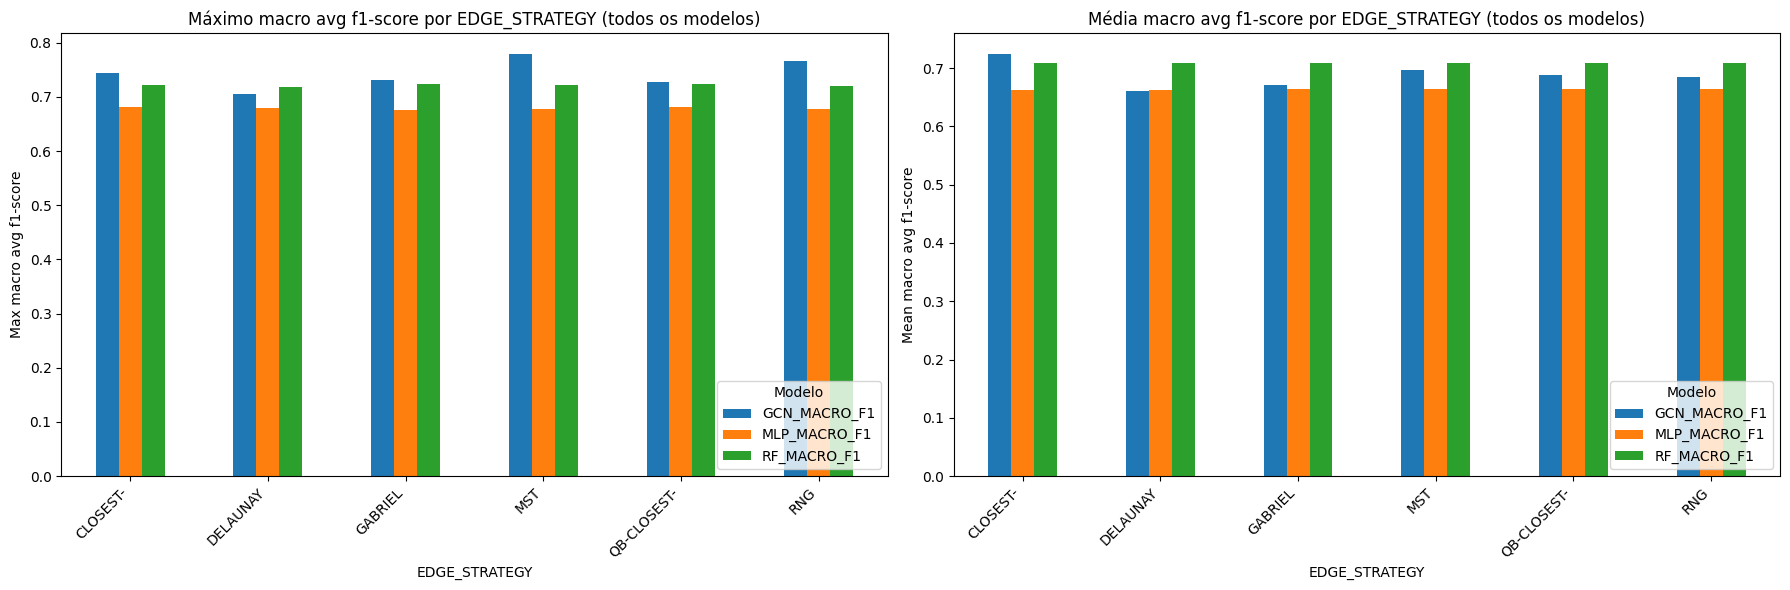

In [75]:
# Gráficos lado a lado: máximo e média de macro avg f1-score de todos os modelos por EDGE_STRATEGY
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Máximo
summary_max = summary.xs('max', axis=1, level=1)
summary_max.plot(kind='bar', ax=axes[0])
axes[0].set_title('Máximo macro avg f1-score por EDGE_STRATEGY (todos os modelos)')
axes[0].set_ylabel('Max macro avg f1-score')
axes[0].set_xlabel('EDGE_STRATEGY')
axes[0].set_xticklabels(summary_max.index, rotation=45, ha='right')
axes[0].legend(title='Modelo', loc='lower right')

# Média
summary_mean = summary.xs('mean', axis=1, level=1)
summary_mean.plot(kind='bar', ax=axes[1])
axes[1].set_title('Média macro avg f1-score por EDGE_STRATEGY (todos os modelos)')
axes[1].set_ylabel('Mean macro avg f1-score')
axes[1].set_xlabel('EDGE_STRATEGY')
axes[1].set_xticklabels(summary_mean.index, rotation=45, ha='right')
axes[1].legend(title='Modelo', loc='lower right')

plt.tight_layout()
plt.show()

### Gráficos: macro avg f1-score (máximo e média) por EDGE_STRATEGY para cada modelo

Abaixo estão gráficos de barras mostrando o valor máximo e a média do macro avg f1-score para cada EDGE_STRATEGY, separados por modelo (GCN, MLP, RF).

## Comparação do macro avg f1-score por EDGE_STRATEGY e QB_LINK

Nesta análise, para cada EDGE_STRATEGY e para cada valor de QB_LINK (True/False), será calculado o valor máximo e a média do campo `macro avg f1-score` para cada modelo (GCN, MLP, RF).

Os resultados são obtidos a partir de uma cópia do dataframe original.

In [76]:
# Nova análise: macro avg f1-score por EDGE_STRATEGY e QB_LINK

df_copy2 = df.copy()

# Função já definida anteriormente: extract_macro_f1
for model in ['GCN', 'MLP', 'RF']:
    df_copy2[f'{model}_MACRO_F1'] = df_copy2[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Agrupa por EDGE_STRATEGY e QB_LINK e calcula máximo e média do macro avg f1-score para cada modelo
agg_funcs = ['max', 'mean']
summary_qb = df_copy2.groupby(['EDGE_STRATEGY', 'QB_LINK'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].agg(agg_funcs)

# Exibe o resultado
summary_qb

GCN_MACRO_F1           MLP_MACRO_F1            \
                               max      mean          max      mean   
EDGE_STRATEGY QB_LINK                                                 
CLOSEST-      False       0.743818  0.720417     0.681617  0.662266   
              True        0.745029  0.728595     0.678988  0.662496   
DELAUNAY      False       0.704524  0.682439     0.676465  0.661667   
              True        0.667076  0.640086     0.679181  0.665057   
GABRIEL       False       0.730670  0.705922     0.676292  0.663580   
              True        0.670400  0.637192     0.673311  0.664052   
MST           False       0.779394  0.758672     0.678063  0.664278   
              True        0.673069  0.636828     0.674783  0.663014   
QB-CLOSEST-   False       0.728351  0.696806     0.680573  0.663538   
              True        0.710748  0.681227     0.677328  0.665516   
RNG           False       0.766915  0.743963     0.676018  0.664041   
              True        0.677243  0.626126     0.677702  0.665180   

                      RF_MACRO_F1            
                              max      mean  
EDGE_STRATEGY QB_LINK                        
CLOSEST-      False      0.722196  0.709462  
              True       0.720079  0.708426  
DELAUNAY      False      0.719191  0.708436  
              True       0.719158  0.709974  
GABRIEL       False      0.723602  0.709358  
              True       0.720912  0.709493  
MST           False      0.719928  0.707724  
              True       0.722000  0.709453  
QB-CLOSEST-   False      0.721776  0.708521  
              True       0.723895  0.709987  
RNG           False      0.720903  0.709057  
              True       0.719765  0.708988

## Comparação do macro avg f1-score por EDGE_STRATEGY e DOWN_SAMPLE

Nesta análise, para cada EDGE_STRATEGY e para cada valor de DOWN_SAMPLE (True/False), será calculado o valor máximo e a média do campo `macro avg f1-score` para cada modelo (GCN, MLP, RF).

Os resultados são obtidos a partir de uma cópia do dataframe original.

In [77]:
# Nova análise: macro avg f1-score por EDGE_STRATEGY e DOWN_SAMPLE

df_copy3 = df.copy()

for model in ['GCN', 'MLP', 'RF']:
    df_copy3[f'{model}_MACRO_F1'] = df_copy3[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

agg_funcs = ['max', 'mean']
summary_down = df_copy3.groupby(['EDGE_STRATEGY', 'DOWN_SAMPLE'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].agg(agg_funcs)

summary_down

GCN_MACRO_F1           MLP_MACRO_F1            \
                                   max      mean          max      mean   
EDGE_STRATEGY DOWN_SAMPLE                                                 
CLOSEST-      False           0.745029  0.731921     0.681617  0.661498   
              True            0.737931  0.717091     0.678988  0.663264   
DELAUNAY      False           0.704524  0.668155     0.677184  0.662177   
              True            0.702623  0.654370     0.679181  0.664546   
GABRIEL       False           0.729781  0.684637     0.676292  0.662495   
              True            0.730670  0.658477     0.675081  0.665138   
MST           False           0.779394  0.707498     0.673854  0.660274   
              True            0.763142  0.688002     0.678063  0.667019   
QB-CLOSEST-   False           0.728351  0.699253     0.677328  0.661713   
              True            0.715408  0.678780     0.680573  0.667341   
RNG           False           0.766915  0.705482     0.677179  0.663131   
              True            0.746461  0.664607     0.677702  0.666090   

                          RF_MACRO_F1            
                                  max      mean  
EDGE_STRATEGY DOWN_SAMPLE                        
CLOSEST-      False          0.711173  0.703700  
              True           0.722196  0.714188  
DELAUNAY      False          0.711047  0.703444  
              True           0.719191  0.714967  
GABRIEL       False          0.711568  0.703413  
              True           0.723602  0.715438  
MST           False          0.713941  0.703347  
              True           0.722000  0.713830  
QB-CLOSEST-   False          0.711568  0.704285  
              True           0.723895  0.714223  
RNG           False          0.713892  0.703694  
              True           0.720903  0.714351

## Melhor configuração para cada modelo

Nesta análise, será identificada a linha do dataframe original que apresenta o maior valor de `macro avg f1-score` para cada modelo (GCN, MLP, RF). Será exibida a configuração completa (colunas de configuração e resultados) correspondente a cada melhor resultado.

In [78]:
# Encontrar a melhor configuração para cada modelo com base no macro avg f1-score

df_best = df.copy()

# Extrai o macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_best[f'{model}_MACRO_F1'] = df_best[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Monta o dataframe de melhores resultados
best_rows = []
for model in ['GCN', 'MLP', 'RF']:
    idx = df_best[f'{model}_MACRO_F1'].idxmax()
    row = df_best.loc[idx]
    best_rows.append({
        'Model': model,
        'Best_Accuracy': row[f'{model}_MACRO_F1'],
        'Edge_Strategy': row['EDGE_STRATEGY'],
        'Down_Sample': row['DOWN_SAMPLE'],
        'QB_Link': row['QB_LINK'],
        'N': row['N'],
        'Random_Seed': row['RANDOM_SEED']
    })

best_df = pd.DataFrame(best_rows)
best_df

,Model,Best_Accuracy,Edge_Strategy,Down_Sample,QB_Link,N,Random_Seed
0,GCN,0.779394,MST,False,False,2,5
1,MLP,0.681617,CLOSEST-,False,False,2,6
2,RF,0.723895,QB-CLOSEST-,True,True,2,8


## Gráfico comparativo: Máximo do macro avg f1-score para as classes Rush e Pass por modelo

O gráfico abaixo mostra, para cada modelo (GCN, MLP, RF), o máximo do f1-score para as classes Rush e Pass.

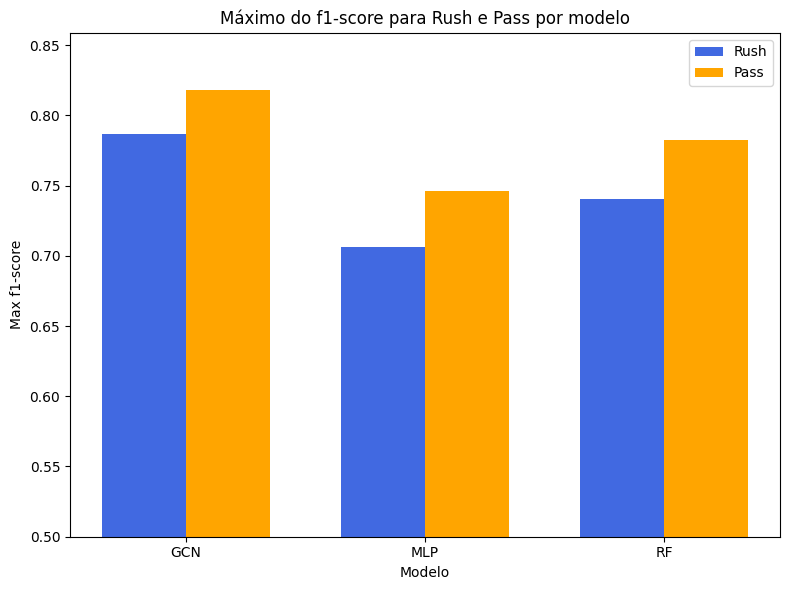

In [79]:
# Extrai os f1-scores das classes Rush e Pass para cada modelo
def extract_f1_class(results, class_name):
    if isinstance(results, dict) and class_name in results and 'f1-score' in results[class_name]:
        return results[class_name]['f1-score']
    return np.nan

means = {}
for model in ['GCN', 'MLP', 'RF']:
    rush_f1 = df[f'{model}_RESULTS'].apply(lambda x: extract_f1_class(x, 'Rush'))
    pass_f1 = df[f'{model}_RESULTS'].apply(lambda x: extract_f1_class(x, 'Pass'))
    means[model] = {
        'Rush': rush_f1.max(),
        'Pass': pass_f1.max()
    }

# Monta o dataframe para plotagem
graph_df = pd.DataFrame(means).T[['Rush', 'Pass']]

# Plota o gráfico
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
x = np.arange(len(graph_df.index))
ax.bar(x - bar_width/2, graph_df['Rush'], bar_width, label='Rush', color='royalblue')
ax.bar(x + bar_width/2, graph_df['Pass'], bar_width, label='Pass', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(graph_df.index)
ax.set_ylabel('Max f1-score')
ax.set_xlabel('Modelo')
ax.set_title('Máximo do f1-score para Rush e Pass por modelo')
ax.set_ylim(bottom=0.5)
ax.legend()
plt.tight_layout()
plt.show()

## Análise do impacto do parâmetro QB_LINK em cada EDGE_STRATEGY e modelo

O gráfico abaixo mostra, para cada EDGE_STRATEGY e para cada modelo (GCN, MLP, RF), a média do macro avg f1-score separando os casos em que QB_LINK é True e False.

/tmp/ipykernel_19984/391491526.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')
/tmp/ipykernel_19984/391491526.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')
/tmp/ipykernel_19984/391491526.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')


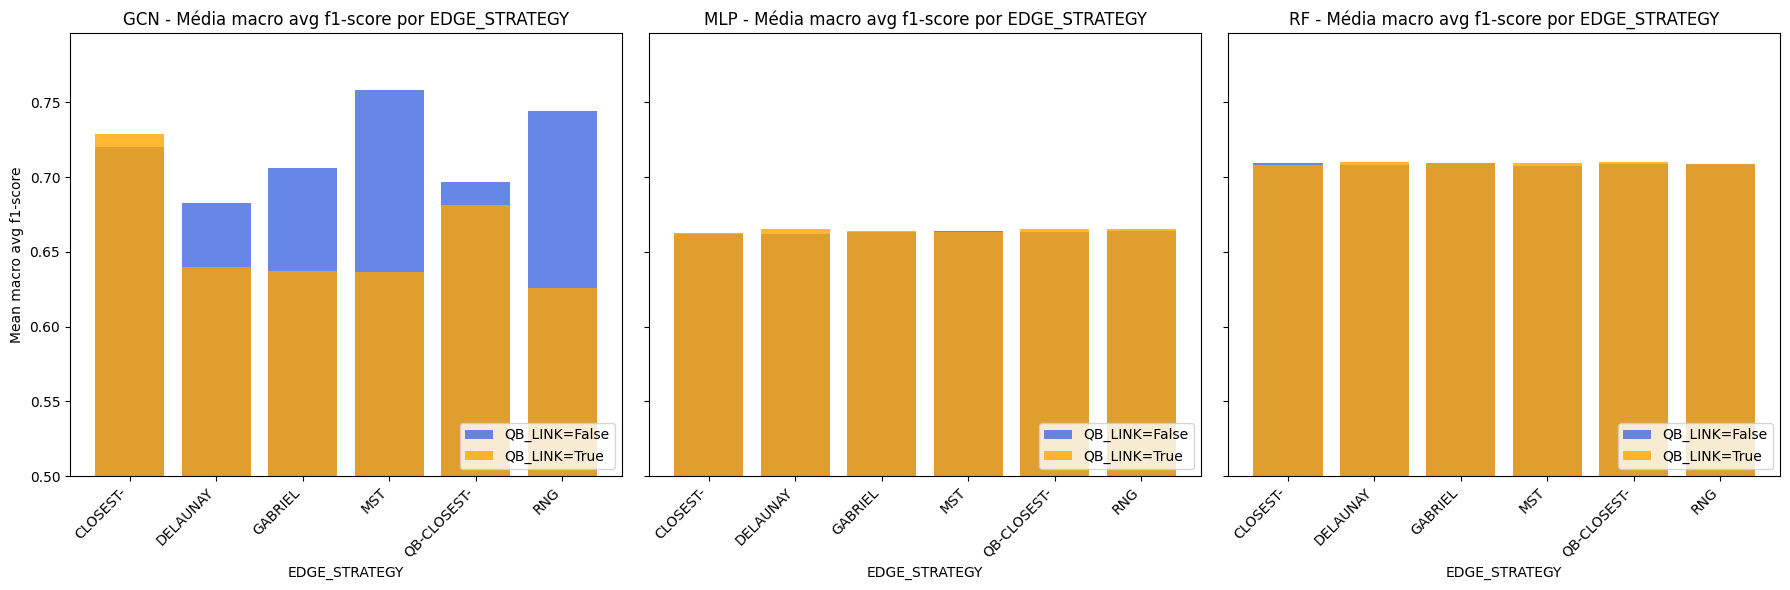

In [83]:
# Análise do impacto do parâmetro QB_LINK para cada EDGE_STRATEGY e modelo

df_qb = df.copy()

# Extrai macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_qb[f'{model}_MACRO_F1'] = df_qb[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Agrupa por EDGE_STRATEGY e QB_LINK e calcula a média do macro avg f1-score para cada modelo
summary_qb = df_qb.groupby(['EDGE_STRATEGY', 'QB_LINK'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].mean().reset_index()

# Plota gráfico para cada modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
models = ['GCN', 'MLP', 'RF']
for i, model in enumerate(models):
    for qb_val, color in zip([False, True], ['royalblue', 'orange']):
        data = summary_qb[summary_qb['QB_LINK'] == qb_val]
        axes[i].bar(data['EDGE_STRATEGY'], data[f'{model}_MACRO_F1'], label=f'QB_LINK={qb_val}', color=color, alpha=0.8)
    axes[i].set_title(f'{model} - Média macro avg f1-score por EDGE_STRATEGY')
    axes[i].set_xlabel('EDGE_STRATEGY')
    axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')
    axes[i].set_ylim(bottom=0.5)
    if i == 0:
        axes[i].set_ylabel('Mean macro avg f1-score')
    axes[i].legend(loc='lower right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_19984/2237217907.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')
/tmp/ipykernel_19984/2237217907.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')
/tmp/ipykernel_19984/2237217907.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')


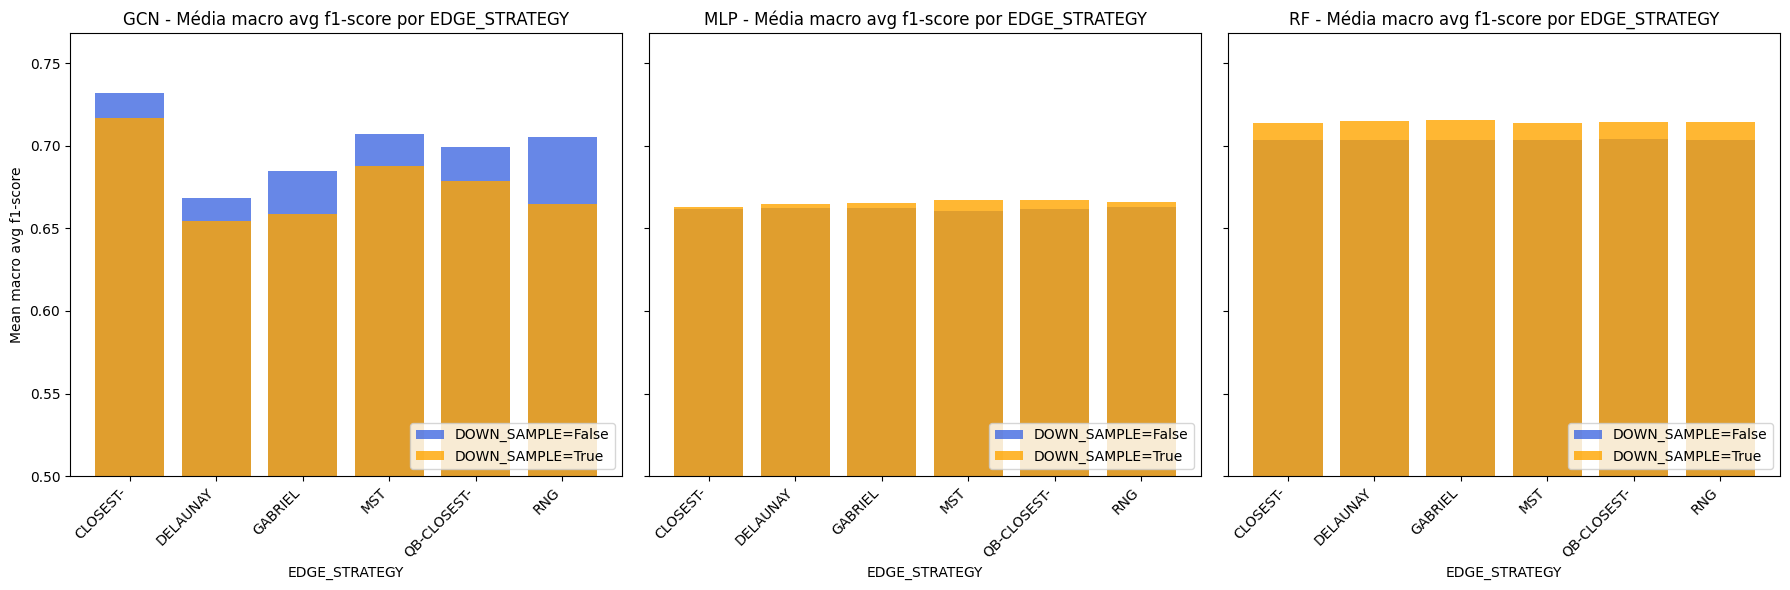

In [84]:
# Análise do impacto do parâmetro DOWN_SAMPLE para cada EDGE_STRATEGY e modelo

df_down = df.copy()

# Extrai macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_down[f'{model}_MACRO_F1'] = df_down[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Agrupa por EDGE_STRATEGY e DOWN_SAMPLE e calcula a média do macro avg f1-score para cada modelo
summary_down = df_down.groupby(['EDGE_STRATEGY', 'DOWN_SAMPLE'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].mean().reset_index()

# Plota gráfico para cada modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
models = ['GCN', 'MLP', 'RF']
for i, model in enumerate(models):
    for down_val, color in zip([False, True], ['royalblue', 'orange']):
        data = summary_down[summary_down['DOWN_SAMPLE'] == down_val]
        axes[i].bar(data['EDGE_STRATEGY'], data[f'{model}_MACRO_F1'], label=f'DOWN_SAMPLE={down_val}', color=color, alpha=0.8)
    axes[i].set_title(f'{model} - Média macro avg f1-score por EDGE_STRATEGY')
    axes[i].set_xlabel('EDGE_STRATEGY')
    axes[i].set_xticklabels(data['EDGE_STRATEGY'], rotation=45, ha='right')
    axes[i].set_ylim(bottom=0.5)
    if i == 0:
        axes[i].set_ylabel('Mean macro avg f1-score')
    axes[i].legend(loc='lower right')
plt.tight_layout()
plt.show()